# Anomaly Detection for Time Series

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (9, 6)

## Read the data

You can download the data from here: https://github.com/numenta/NAB/blob/master/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv
And the labels from here: https://github.com/numenta/NAB/blob/master/labels/combined_labels.json

In [5]:
df = pd.read_csv("NAB/ec2_cpu_utilization_24ae8d.csv") # Download from the link above
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [6]:
anomalies_timestamp = [
    "2014-02-26 22:05:00",
    "2014-02-27 17:15:00"
]

In [7]:
# Convert to timestamp
df["timestamp"] = pd.to_datetime(df["timestamp"])

df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [8]:
# Add an anomaly label
df["is_anomaly"] = 1

for each in anomalies_timestamp:
    df.loc[df["timestamp"] == each, "is_anomaly"] = -1

df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [9]:
anomaly_df = df.loc[df["is_anomaly"] == -1]
inlier_df = df.loc[df["is_anomaly"] == 1]

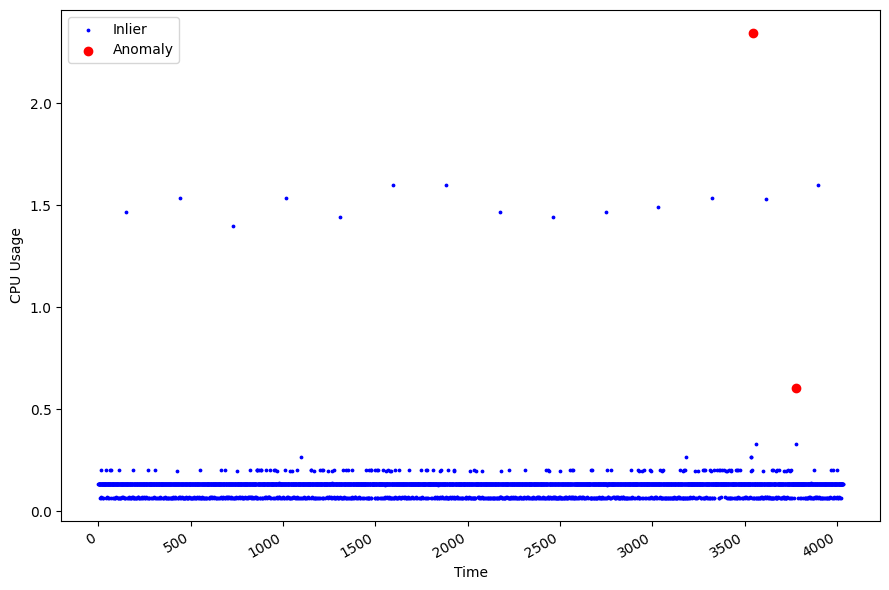

In [10]:
fig, ax = plt.subplots()

ax.scatter(inlier_df.index, inlier_df["value"], color="blue", s=3, label="Inlier")
ax.scatter(anomaly_df.index, anomaly_df["value"], color="red", label="Anomaly")
ax.set_xlabel("Time")
ax.set_ylabel("CPU Usage")
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

## Baseline: Median Absolute Deviation (MAD)

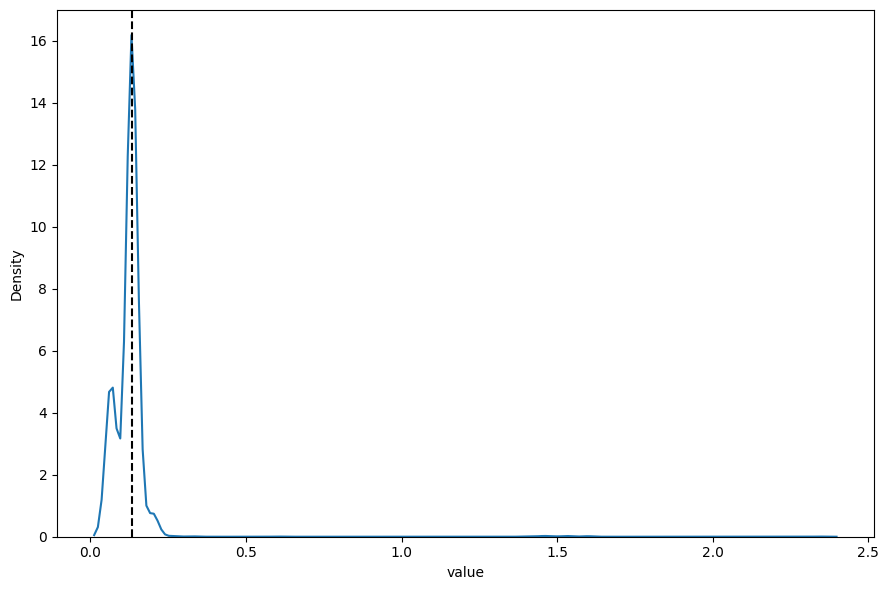

In [12]:
import seaborn as sns

sns.kdeplot(df["value"])
plt.grid(False)
plt.axvline(0.134, 0, 1, c="black", ls="--")
plt.tight_layout()
plt.show()

In [14]:
from scipy.stats import median_abs_deviation

mad = median_abs_deviation(df["value"])
median = np.median(df["value"])

print(mad)
print(median)

def compute_robust_z_score(x):
    return 0.6745*(x-median)/mad

0.0020000000000000018
0.134


In [15]:
# Compute the robust Z-score for each sample
df["z-score"] = df["value"].apply(compute_robust_z_score)

df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [17]:
# Determine if it is an anomaly (use a threshold of 3.5)

df["baseline"] = 1

df.loc[df["z-score"] >= 3.5, "baseline"] = -1
df.loc[df["z-score"] <= -3.5, "baseline"] = -1

### Evaluation

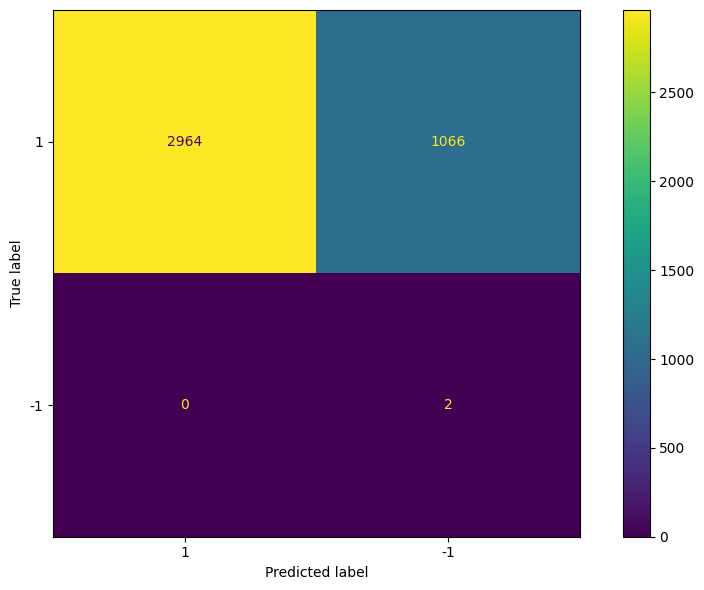

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot the confusion matrix
cm = confusion_matrix(df["is_anomaly"], df["baseline"], labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()

## Isolation Forest